<a href="https://colab.research.google.com/github/2025em1100480-droid/APEX-PROJECT-I/blob/Phase2-Anitha/Neaural_Nexus_Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


###                  ADVANCED APEX PROJECT I
PROJECT TITLE: Customer Segmentation Model for E-commerce Company

PROBLEM STATEMENT:
The e-commerce retailer aims to utilize customer purchase history to segment
its customer base into actionable groups. The goal is to drive targeted marketing
and upselling strategies that enhance customer engagement, retention, and lifetime value.

BUSINESS GOAL:
1. Understand customer behavior through segmentation based on purchase history
2. Design personalized marketing campaigns for each segment
3. Identify upselling and cross-selling opportunities
4. Maximize customer lifetime value

DATA SOURCE: Kaggle - Online Retail Dataset
- Direct link available or via Kaggle API

TOOLS USED:
- Python (Pandas, NumPy for data manipulation)
- Matplotlib & Seaborn for visualizations
- Scikit-learn for feature engineering
- Jupyter Notebook for documentation

WORKFLOW:
Data Acquisition → Data Audit & Cleaning → EDA → Feature Engineering →
RFM Analysis → Customer Segmentation → Visualization & Insights





#  PHASE 1: PROPOSAL & DATA ACQUISITION



### Accessing the Downloaded .csv Dataset File

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/2025em1100480-droid/APEX-PROJECT-I/Phase2-Anitha/online_retail.csv", encoding='latin1')

In [5]:
# Step 1: Install the KaggleHub library
# The '!' command runs a shell command in Google Colab/Jupyter.
!pip install kagglehub

# Step 2: Import the necessary libraries
import kagglehub

import os # This library helps work with file paths



# DATA EXTRACTION


In [17]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load data from GitHub/Kaggle
df = pd.read_csv("https://raw.githubusercontent.com/2025em1100480-droid/APEX-PROJECT-I/Phase2-Anitha/online_retail.csv",
                  encoding='latin1')

print(f"✅ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"File size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")



✅ Dataset loaded successfully!
Dataset shape: (541909, 8)
File size: 175.20 MB



# DATA SCHEMA / DATA DICTIONARY


In [ ]:


print("\n" + "=" * 80)
print("DATA SCHEMA - DATA DICTIONARY")
print("=" * 80)

schema_dict = {
    'Feature': ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
                'UnitPrice', 'CustomerID', 'Country'],
    'Data Type': ['String', 'String', 'String', 'Integer', 'DateTime',
                  'Float', 'Float', 'String'],
    'Description': [
        'Unique invoice number',
        'Product stock code',
        'Product description',
        'Quantity ordered',
        'Date and time of purchase',
        'Price per unit',
        'Unique customer identifier',
        'Customer country'
    ],
    'Primary Key': ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No'],
    'Nullable': ['No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No']
}

schema_df = pd.DataFrame(schema_dict)
print(schema_df.to_string(index=False))

print("\n✅ Note: No single column is Primary Key. (InvoiceNo, StockCode) forms composite key.")




# PHASE 2: PREPROCESSING & FEATURE ENGINEERING



DATA SCHEMA - DATA DICTIONARY
    Feature Data Type                Description Primary Key Nullable
  InvoiceNo    String      Unique invoice number          No       No
  StockCode    String         Product stock code          No       No
Description    String        Product description          No      Yes
   Quantity   Integer           Quantity ordered          No       No
InvoiceDate  DateTime  Date and time of purchase          No       No
  UnitPrice     Float             Price per unit          No       No
 CustomerID     Float Unique customer identifier          No      Yes
    Country    String           Customer country          No       No

✅ Note: No single column is Primary Key. (InvoiceNo, StockCode) forms composite key.

PHASE 2: DATA PREPROCESSING & FEATURE ENGINEERING

### STEP 1: DATA AUDIT & AVAILABILITY CHECK ###

Dataset Shape: (541909, 8)

Data Types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     obje

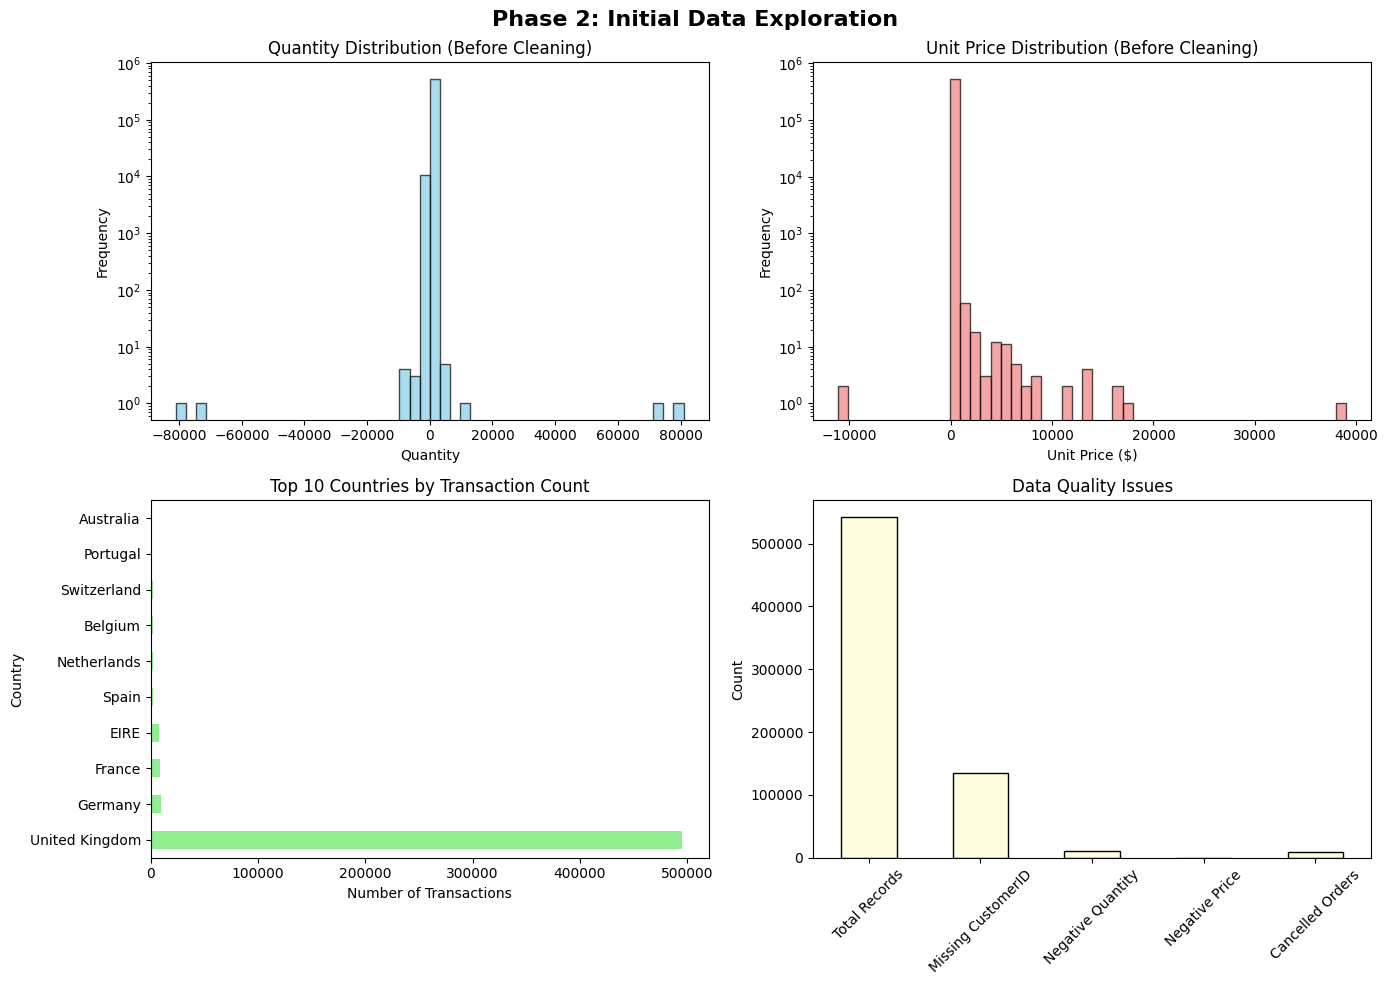


### STEP 3: DATA CLEANING ###

✅ Removed 135080 rows with missing CustomerID
✅ Removed 8905 cancelled orders
✅ Removed 40 rows with negative/zero values
✅ Converted InvoiceDate to datetime
✅ Converted CustomerID to integer

Cleaned Dataset Shape: (397884, 8)

### STEP 4: HANDLE OUTLIERS ###

UnitPrice range (1st-99th percentile): $0.21 - $14.95
✅ Removed 6725 outliers
Final Dataset Shape: (391159, 8)


In [18]:


print("\n" + "=" * 80)
print("PHASE 2: DATA PREPROCESSING & FEATURE ENGINEERING")
print("=" * 80)

# ============================================================================
# STEP 1: DATA AUDIT & DATA AVAILABILITY CHECK
# ============================================================================

print("\n### STEP 1: DATA AUDIT & AVAILABILITY CHECK ###\n")

print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
missing_data = df.isnull().sum()
print(missing_data)
print(f"\nPercentage of Missing Values:")
print((missing_data / len(df) * 100).round(2))

print("\nBasic Statistics:")
print(df.describe())

# Check for quality flags
print("\nData Quality Flags:")
print(f"  - Negative Quantity: {(df['Quantity'] < 0).sum()}")
print(f"  - Negative UnitPrice: {(df['UnitPrice'] < 0).sum()}")
print(f"  - Zero Quantity: {(df['Quantity'] == 0).sum()}")
print(f"  - Cancelled Orders: {df['InvoiceNo'].astype(str).str.startswith('C').sum()}")

# ============================================================================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n### STEP 2: EXPLORATORY DATA ANALYSIS ###\n")

print("Summary Statistics:")
print(df[['Quantity', 'UnitPrice', 'CustomerID']].describe())

print("\nUnique Values:")
print(f"  - Unique Customers: {df['CustomerID'].nunique()}")
print(f"  - Unique Products: {df['StockCode'].nunique()}")
print(f"  - Unique Countries: {df['Country'].nunique()}")
print(f"  - Unique Invoices: {df['InvoiceNo'].nunique()}")

# ============================================================================
# VISUALIZATION 1: INITIAL DATA EXPLORATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Phase 2: Initial Data Exploration', fontsize=16, fontweight='bold')

# 1. Quantity Distribution
axes[0, 0].hist(df['Quantity'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Quantity Distribution (Before Cleaning)')
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# 2. Unit Price Distribution
axes[0, 1].hist(df['UnitPrice'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Unit Price Distribution (Before Cleaning)')
axes[0, 1].set_xlabel('Unit Price ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')

# 3. Top 10 Countries
top_countries = df['Country'].value_counts().head(10)
top_countries.plot(kind='barh', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Top 10 Countries by Transaction Count')
axes[1, 0].set_xlabel('Number of Transactions')

# 4. Data Quality Issues
quality_issues = pd.Series({
    'Total Records': len(df),
    'Missing CustomerID': df['CustomerID'].isnull().sum(),
    'Negative Quantity': (df['Quantity'] < 0).sum(),
    'Negative Price': (df['UnitPrice'] < 0).sum(),
    'Cancelled Orders': df['InvoiceNo'].astype(str).str.startswith('C').sum()
})
quality_issues.plot(kind='bar', ax=axes[1, 1], color='lightyellow', edgecolor='black')
axes[1, 1].set_title('Data Quality Issues')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 3: DATA CLEANING
# ============================================================================

print("\n### STEP 3: DATA CLEANING ###\n")

initial_rows = len(df)

# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])
print(f"✅ Removed {initial_rows - len(df)} rows with missing CustomerID")
initial_rows = len(df)

# Remove cancelled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print(f"✅ Removed {initial_rows - len(df)} cancelled orders")
initial_rows = len(df)

# Remove negative Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print(f"✅ Removed {initial_rows - len(df)} rows with negative/zero values")

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print("✅ Converted InvoiceDate to datetime")

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)
print("✅ Converted CustomerID to integer")

print(f"\nCleaned Dataset Shape: {df.shape}")

# ============================================================================
# STEP 4: HANDLE OUTLIERS
# ============================================================================

print("\n### STEP 4: HANDLE OUTLIERS ###\n")

q1 = df['UnitPrice'].quantile(0.01)
q99 = df['UnitPrice'].quantile(0.99)
print(f"UnitPrice range (1st-99th percentile): ${q1:.2f} - ${q99:.2f}")

initial_rows = len(df)
df = df[(df['UnitPrice'] >= q1) & (df['UnitPrice'] <= q99)]
print(f"✅ Removed {initial_rows - len(df)} outliers")

print(f"Final Dataset Shape: {df.shape}")










# STEP 5: FEATURE ENGINEERING


In [19]:


print("\n### STEP 5: FEATURE ENGINEERING ###\n")

# Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print("✅ Created TotalPrice = Quantity × UnitPrice")

# Temporal Features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour
df['Day'] = df['InvoiceDate'].dt.day
print("✅ Created temporal features (Year, Month, DayOfWeek, Hour, Day)")

# Aggregate Customer Features
print("\nCreating customer-level features...")

customer_features = df.groupby('CustomerID').agg({
    'TotalPrice': ['sum', 'mean', 'count'],
    'Quantity': ['sum', 'mean'],
    'InvoiceNo': 'nunique',
    'StockCode': 'nunique',
    'Country': lambda x: x.mode()[0],
    'InvoiceDate': ['min', 'max']
}).reset_index()

customer_features.columns = ['CustomerID', 'Total_Spend', 'Avg_Spend',
                             'Purchase_Count', 'Total_Quantity', 'Avg_Quantity',
                             'Unique_Invoices', 'Unique_Products', 'Primary_Country',
                             'First_Purchase', 'Last_Purchase']

customer_features['Customer_Lifespan_Days'] = (customer_features['Last_Purchase'] -
                                               customer_features['First_Purchase']).dt.days

customer_features['Transaction_Frequency'] = (customer_features['Purchase_Count'] /
                                              (customer_features['Customer_Lifespan_Days'] + 1))

# Value Segmentation
high_value_threshold = customer_features['Total_Spend'].quantile(0.75)
customer_features['Is_HighValue'] = (customer_features['Total_Spend'] >= high_value_threshold).astype(int)

latest_date = df['InvoiceDate'].max()
cutoff_date = latest_date - pd.Timedelta(days=90)
active_customers = df[df['InvoiceDate'] >= cutoff_date]['CustomerID'].unique()
customer_features['Is_Active_90Days'] = customer_features['CustomerID'].isin(active_customers).astype(int)

print("✅ Created customer aggregated features")
print(f"✅ Customer Features Shape: {customer_features.shape}")



### STEP 5: FEATURE ENGINEERING ###

✅ Created TotalPrice = Quantity × UnitPrice
✅ Created temporal features (Year, Month, DayOfWeek, Hour, Day)

Creating customer-level features...
✅ Created customer aggregated features
✅ Customer Features Shape: (4325, 15)



# VISUALIZATION 2: CLEANED DATA OVERVIEW


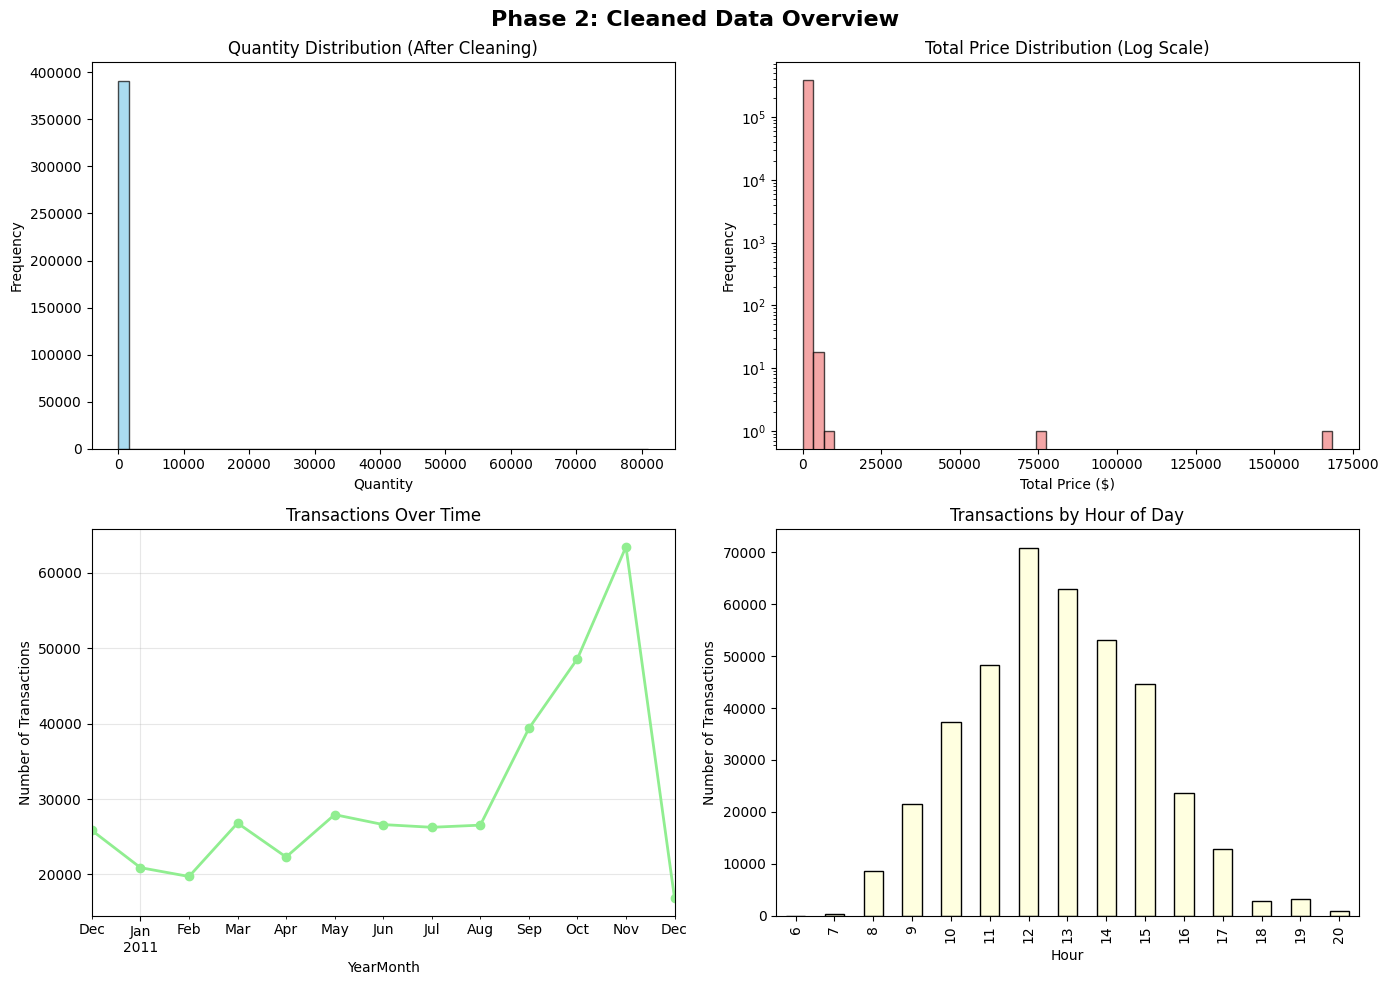

In [20]:


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Phase 2: Cleaned Data Overview', fontsize=16, fontweight='bold')

# 1. Cleaned Quantity Distribution
axes[0, 0].hist(df['Quantity'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Quantity Distribution (After Cleaning)')
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Frequency')

# 2. Total Price Distribution
axes[0, 1].hist(df['TotalPrice'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Total Price Distribution (Log Scale)')
axes[0, 1].set_xlabel('Total Price ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')

# 3. Transactions by Month
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_trans = df.groupby('YearMonth').size()
monthly_trans.plot(kind='line', ax=axes[1, 0], marker='o', color='lightgreen', linewidth=2)
axes[1, 0].set_title('Transactions Over Time')
axes[1, 0].set_ylabel('Number of Transactions')
axes[1, 0].grid(True, alpha=0.3)

# 4. Transactions by Hour
hourly_trans = df.groupby('Hour').size()
hourly_trans.plot(kind='bar', ax=axes[1, 1], color='lightyellow', edgecolor='black')
axes[1, 1].set_title('Transactions by Hour of Day')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].set_xlabel('Hour')

plt.tight_layout()
plt.show()


# VISUALIZATION 3: CUSTOMER FEATURES ANALYSIS


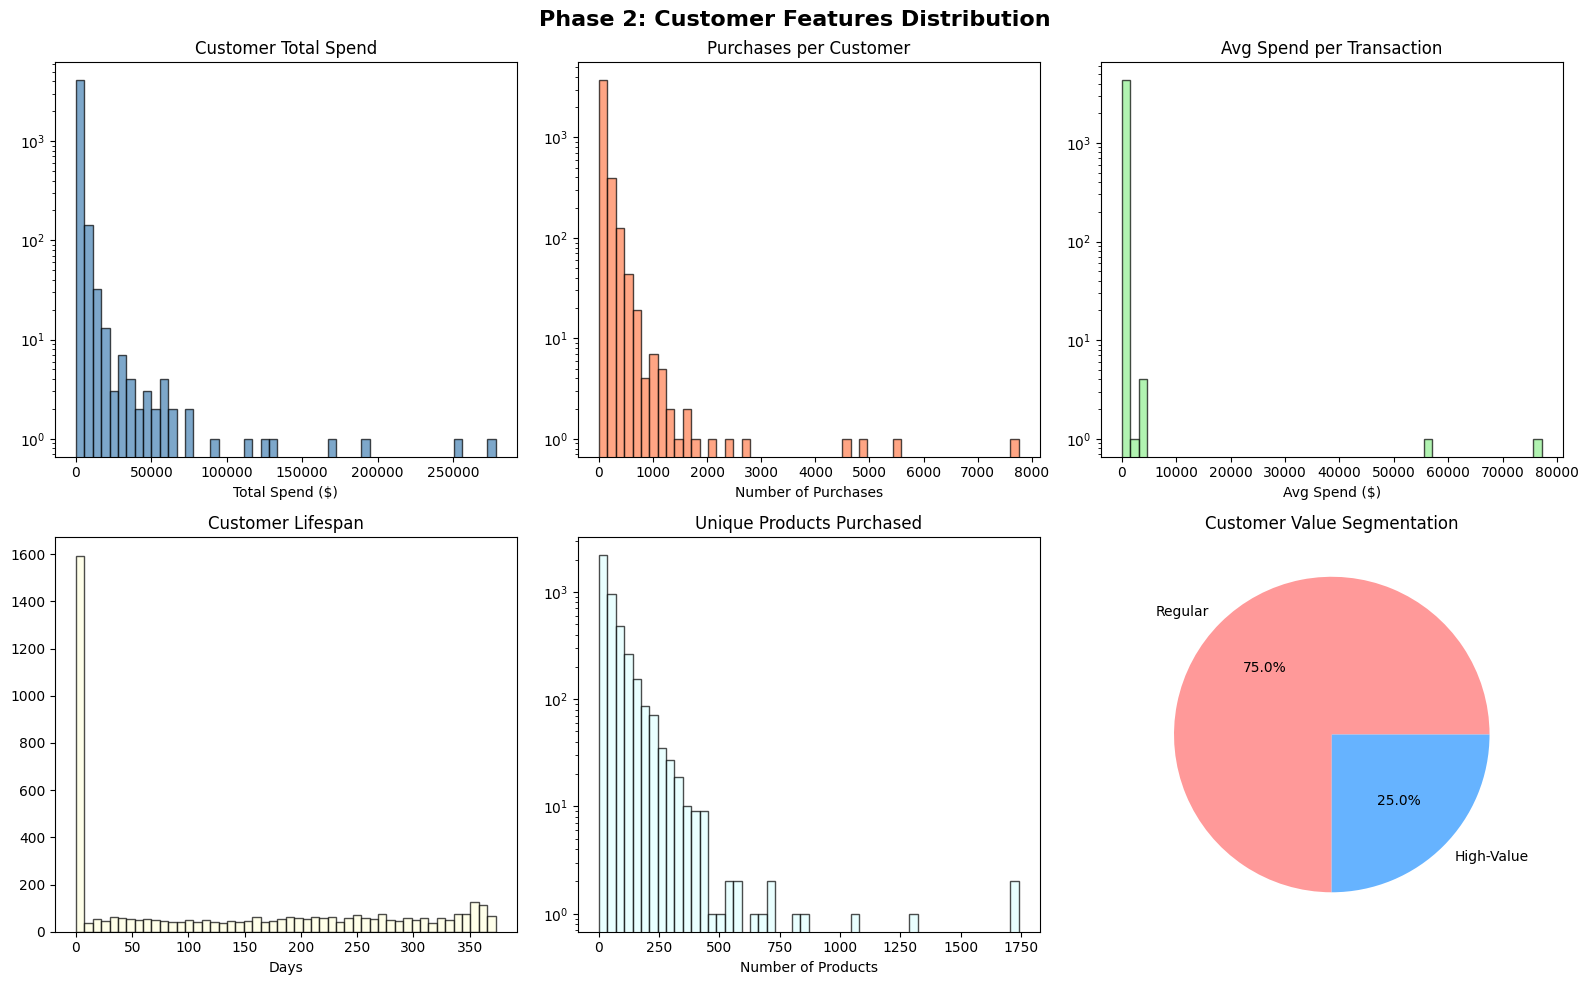

In [21]:


fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Phase 2: Customer Features Distribution', fontsize=16, fontweight='bold')

# 1. Total Spend
axes[0, 0].hist(customer_features['Total_Spend'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Customer Total Spend')
axes[0, 0].set_xlabel('Total Spend ($)')
axes[0, 0].set_yscale('log')

# 2. Purchase Count
axes[0, 1].hist(customer_features['Purchase_Count'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Purchases per Customer')
axes[0, 1].set_xlabel('Number of Purchases')
axes[0, 1].set_yscale('log')

# 3. Avg Spend per Transaction
axes[0, 2].hist(customer_features['Avg_Spend'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Avg Spend per Transaction')
axes[0, 2].set_xlabel('Avg Spend ($)')
axes[0, 2].set_yscale('log')

# 4. Customer Lifespan
axes[1, 0].hist(customer_features['Customer_Lifespan_Days'], bins=50, color='lightyellow', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Customer Lifespan')
axes[1, 0].set_xlabel('Days')

# 5. Unique Products
axes[1, 1].hist(customer_features['Unique_Products'], bins=50, color='lightcyan', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Unique Products Purchased')
axes[1, 1].set_xlabel('Number of Products')
axes[1, 1].set_yscale('log')

# 6. Value Segmentation
value_seg = customer_features['Is_HighValue'].value_counts()
axes[1, 2].pie(value_seg, labels=['Regular', 'High-Value'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
axes[1, 2].set_title('Customer Value Segmentation')

plt.tight_layout()
plt.show()


# VISUALIZATION 4: PRIMARY KEY ANALYSIS


In [22]:


print("\n### PRIMARY KEY ANALYSIS ###\n")

print("Checking potential Primary Keys:")
print(f"\n1. InvoiceNo: {df['InvoiceNo'].nunique()} unique values out of {len(df)} rows")
print(f"   - Contains duplicates: {df['InvoiceNo'].duplicated().sum()}")

print(f"\n2. StockCode: {df['StockCode'].nunique()} unique values out of {len(df)} rows")
print(f"   - Contains duplicates: {df['StockCode'].duplicated().sum()}")

print(f"\n3. CustomerID: {df['CustomerID'].nunique()} unique values out of {len(df)} rows")
print(f"   - Contains duplicates: {df['CustomerID'].duplicated().sum()}")

print(f"\n4. Composite Key (InvoiceNo, StockCode):")
composite_key = df.groupby(['InvoiceNo', 'StockCode']).size()
print(f"   - Unique combinations: {len(composite_key)}")
print(f"   - Is unique: {len(composite_key) == len(df)}")

print("\n✅ RECOMMENDATION:")
print("   Primary Key: (InvoiceNo, StockCode) - Composite Key")
print("   Reason: Each product can only appear once per invoice")
print("   Foreign Key: CustomerID references Customers table")



### PRIMARY KEY ANALYSIS ###

Checking potential Primary Keys:

1. InvoiceNo: 18351 unique values out of 391159 rows
   - Contains duplicates: 372808

2. StockCode: 3595 unique values out of 391159 rows
   - Contains duplicates: 387564

3. CustomerID: 4325 unique values out of 391159 rows
   - Contains duplicates: 386834

4. Composite Key (InvoiceNo, StockCode):
   - Unique combinations: 381248
   - Is unique: False

✅ RECOMMENDATION:
   Primary Key: (InvoiceNo, StockCode) - Composite Key
   Reason: Each product can only appear once per invoice
   Foreign Key: CustomerID references Customers table



# SUMMARY & STATISTICS


In [23]:


print("\n" + "=" * 80)
print("PHASE 2 SUMMARY")
print("=" * 80)

print(f"\n📊 Dataset Statistics:")
print(f"   Original Records: {len(df)}")
print(f"   After Cleaning: {len(df)}")
print(f"   Total Unique Customers: {df['CustomerID'].nunique()}")
print(f"   Total Unique Products: {df['StockCode'].nunique()}")
print(f"   Countries: {df['Country'].nunique()}")

print(f"\n💰 Financial Summary:")
print(f"   Total Revenue: ${df['TotalPrice'].sum():,.2f}")
print(f"   Average Transaction Value: ${df['TotalPrice'].mean():,.2f}")
print(f"   Median Transaction Value: ${df['TotalPrice'].median():,.2f}")

print(f"\n👥 Customer Summary:")
print(f"   High-Value Customers (Top 25%): {customer_features['Is_HighValue'].sum()}")
print(f"   Active Customers (Last 90 days): {customer_features['Is_Active_90Days'].sum()}")
print(f"   Average Spend per Customer: ${customer_features['Total_Spend'].mean():,.2f}")
print(f"   Average Purchases per Customer: {customer_features['Purchase_Count'].mean():.1f}")

print("\n" + "=" * 80)
print("✅ PHASE 1 & 2 COMPLETE")
print("=" * 80)


PHASE 2 SUMMARY

📊 Dataset Statistics:
   Original Records: 391159
   After Cleaning: 391159
   Total Unique Customers: 4325
   Total Unique Products: 3595
   Countries: 37

💰 Financial Summary:
   Total Revenue: $8,589,547.76
   Average Transaction Value: $21.96
   Median Transaction Value: $11.80

👥 Customer Summary:
   High-Value Customers (Top 25%): 1082
   Active Customers (Last 90 days): 2881
   Average Spend per Customer: $1,986.02
   Average Purchases per Customer: 90.4

✅ PHASE 1 & 2 COMPLETE
